In [1]:
#relevant libraries
import pystan
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import seaborn

In [2]:
#read in data
df=pd.read_csv("weekly_in_situ_co2_mlo.csv")
df['date'] = pd.to_datetime(df['date']) #transform to pd date format

In [3]:
#transform date to count how much time since 1958 in yrs
df['date_yrs'] = [(df.date[i] - df.date[0]).days 
                      / 365.25 for i in range(len(df.date))]

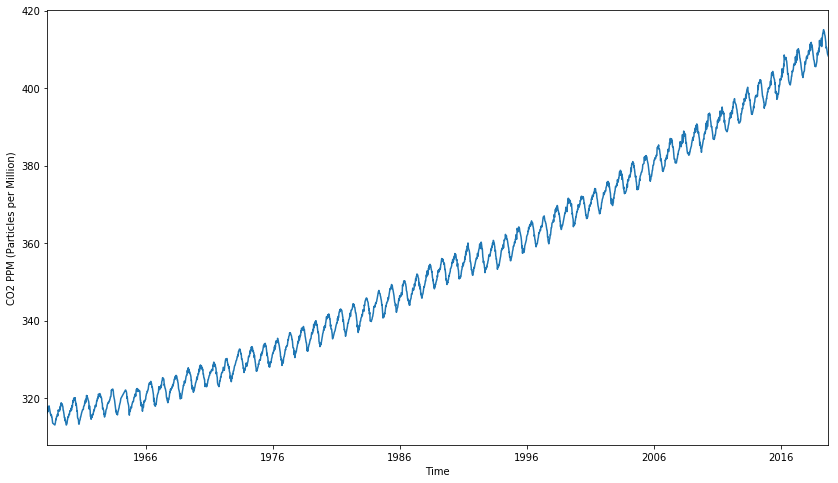

In [4]:
#visualize data
plt.figure(figsize=(14,8))
plt.plot(df.date.values,df.co2.values)
plt.xlabel("Time")
plt.ylabel("CO2 PPM (Particles per Million)")
plt.xlim(df.date.values[0],df.date.values[-1])
plt.savefig("intro1.png",dpi=400)

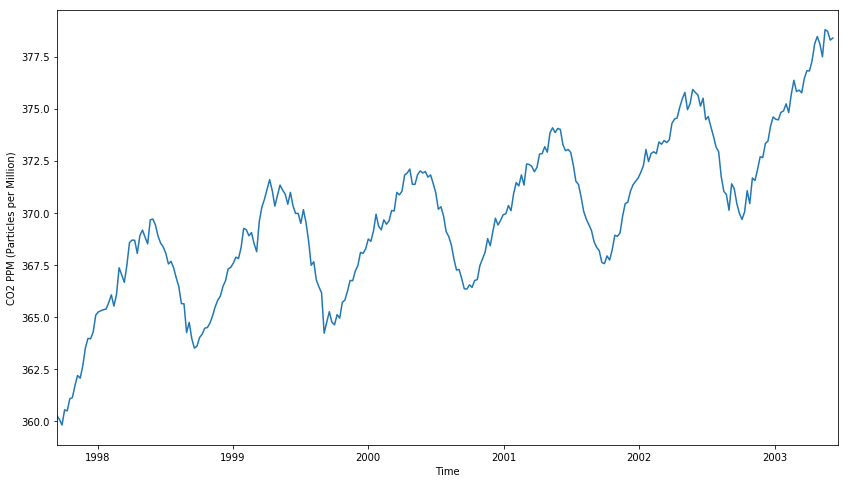

In [5]:
#show seasonality
plt.figure(figsize=(14,8))
plt.plot(df.date.values[2000:2300],df.co2.values[2000:2300])
plt.xlabel("Time")
plt.ylabel("CO2 PPM (Particles per Million)")
plt.xlim(df.date.values[2000],df.date.values[2300])
plt.savefig("intro2.png",dpi=400)

In [6]:
#stan model for linear trend
stan_data = {
    "n_data" : len(df),
    "time" : df.date_yrs.values,
    "co2" : df.co2.values,
}

linear_stan_code = """
data {
    int<lower=0> n_data;             // length of data
    real<lower=0> time[n_data];      // time since beginning of study
    real co2[n_data];               // co2 data
}
parameters {
    real<lower=0> c0;  // y intercept
    real<lower=0> c1;  // gradient
    real<lower=0> c4;   // noise parameter in normal
} 
model {
 
    // Priors
    c0 ~ normal(300, 30);
    c1 ~ normal(0.75,0.5);
    c4 ~ cauchy(8,3);
    for (i in 1:n_data) {
        co2[i] ~ normal(c1*time[i]+c0, c4); 
    }
}
"""
linear = pystan.StanModel(model_code=linear_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c40b508a4eb87af9f329ccc79983413f NOW.
C:\Users\Armin\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Armin\AppData\Local\Temp\tmpwotl2pvk\stanfit4anon_model_c40b508a4eb87af9f329ccc79983413f_5936229401505685894.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
#extract results
linear_results = linear.sampling(data=stan_data)
linear_samples = linear_results.extract()
linear_line = linear_samples['c0'].mean() + linear_samples['c1'].mean()*df.date_yrs.values

C:\Users\Armin\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


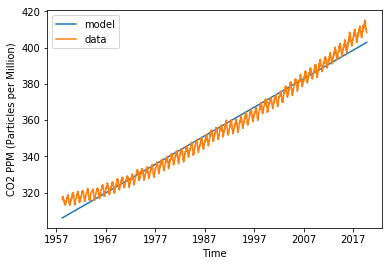

In [8]:
#see how it fits the data
plt.figure()
plt.plot(df.date.values,linear_line,label="model")
plt.plot(df.date.values,df.co2.values,label="data")
plt.xlabel("Time")
plt.ylabel("CO2 PPM (Particles per Million)")
plt.legend()
plt.savefig("linear.png",dpi=400)

In [9]:
#stan model for a quadratic trend
quadratic_stan_code = """
data {
    int<lower=0> n_data;             // length of data
    real<lower=0> time[n_data];      // time since beginning of study
    real co2[n_data];               // co2 data
}
parameters {
    real<lower=0> c0;  // y intercept
    real<lower=0> c1;  // linear term
    real<lower=0> c2;  // quadratic term
    real<lower=0> c4;  // noise parameter in normal
} 
model {
 
    // Priors
    c0 ~ normal(300, 30);
    c1 ~ normal(0,5);
    c2 ~ normal(1,1);
    c4 ~ cauchy(10,5);
    for (i in 1:n_data) {
        co2[i] ~ normal(c2*time[i]^2+c1*time[i]+c0, c4); 
    }
}
"""
quadratic = pystan.StanModel(model_code=quadratic_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_44d4c16ce2dcf27dd953789758b43a86 NOW.
C:\Users\Armin\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Armin\AppData\Local\Temp\tmp8rs8vf1n\stanfit4anon_model_44d4c16ce2dcf27dd953789758b43a86_4231097925799254741.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
#extractresults
quadratic_results = quadratic.sampling(data=stan_data)
quadratic_samples = quadratic_results.extract()

quadratic_line = (quadratic_samples['c0'].mean() +
                 quadratic_samples['c1'].mean()*df.date_yrs.values +
                quadratic_samples['c2'].mean()*df.date_yrs.values**2)

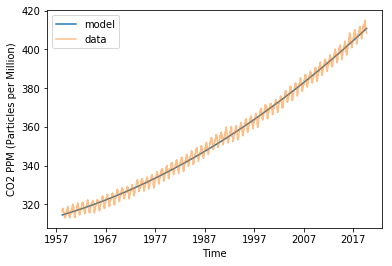

In [11]:
#see how it fits the data
plt.figure()
plt.plot(df.date.values,quadratic_line,label="model")
plt.plot(df.date.values,df.co2.values,alpha=.5,label='data')
plt.xlabel("Time")
plt.ylabel("CO2 PPM (Particles per Million)")
plt.legend()
plt.savefig("quadratic.png",dpi=400)

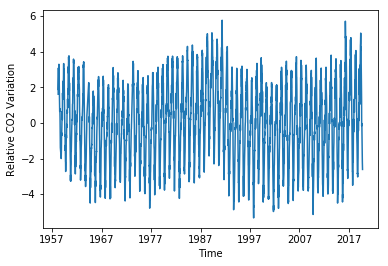

In [12]:
#seasonality
#remove quadratic trend to get seasonal variation
df['seasonality']=df.co2-quadratic_line
plt.figure()
plt.plot(df.date.values,df.seasonality.values)
plt.xlabel("Time")
plt.ylabel("Relative CO2 Variation")
#plt.legend()
plt.savefig("seasonality.png",dpi=400)

In [13]:
#save data just in case
df.to_csv("seasonality.csv", encoding='utf-8', index=False)

In [14]:
dfs = df[2800:3100]
dfs.to_csv("seasonality.csv", encoding='utf-8', index=False)

In [15]:
# seasonality suggested  in assignment
seasonal_data = {
    "n_data" : len(dfs),
    "time" : dfs.date_yrs.values,
    "co2" : dfs.seasonality.values,
    "two_pi" : 2*np.pi
}

cos_seasonal_stan_code = """
data {
    int<lower=0> n_data;             // length of data
    real<lower=0> time[n_data];      // time since beginning of study
    real co2[n_data];               // co2 data
    real<lower=0> two_pi;
    
}
parameters {
    real<lower=0> c2;  //amplitude
    real<lower=0> c4;        // noise parameter in normal
    // We need a periodic c3 offset
    real c3_x;
    real c3_y;
} 
transformed parameters {
    real c3 = atan2(c3_x,c3_y) ;
}
model {
 
    // Priors
    c3_x ~ normal(0,0.5);
    c3_y ~ normal(0,0.5);
    c2 ~ inv_gamma(6, 1);
    c4 ~ cauchy(0,2);
    for (i in 1:n_data) {
        co2[i] ~ normal(c2*cos(two_pi*time[i]+c3), c4); 
    }
}
"""
cos_seasonal_model = pystan.StanModel(model_code=cos_seasonal_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c94949bdad0de4408ab99820e934fb73 NOW.
C:\Users\Armin\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Armin\AppData\Local\Temp\tmpwox3r_pi\stanfit4anon_model_c94949bdad0de4408ab99820e934fb73_5030073975174280979.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [16]:
#extract results
cos_seasonal_results = cos_seasonal_model.sampling(data=seasonal_data, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)
cos_seasonal_samples = cos_seasonal_results.extract()
cos_seasonal_line = (cos_seasonal_samples['c2'].mean()
                     *np.cos(2*np.pi*dfs.date_yrs.values+cos_seasonal_samples['c3'].mean()))

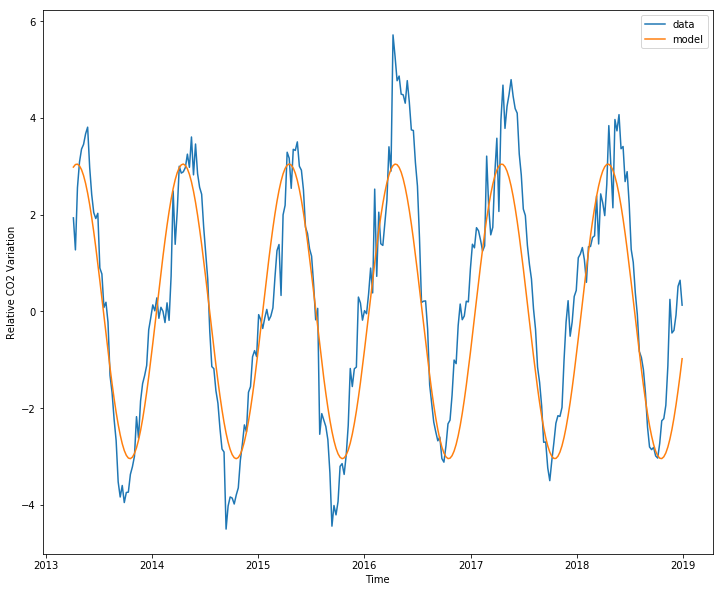

In [17]:
#see how it fits the data
plt.figure(figsize=(12,10))
plt.plot(dfs.date.values,dfs.seasonality.values,label="data")
plt.plot(dfs.date.values,cos_seasonal_line,label="model")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Relative CO2 Variation")
plt.savefig("cosine.png",dpi=400)

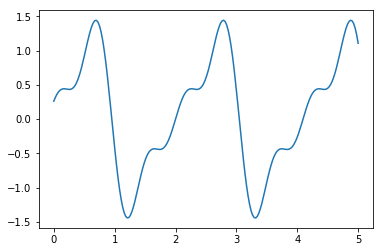

In [18]:
#trial to code fourier harmonics (I could not run it in the end)
def f(x,a,b,c):
    #fourier harmonics
    x=((x-c)/b) #x/frequency-offset
    result= (np.sin(x)-1/2*np.sin(2*x)+1/3*np.sin(3*x))
    return a*result
x=np.linspace(0,5,200)
y=[f(i,1,1/3,2) for i in x]
plt.figure()
plt.plot(x,y)
plt.show()

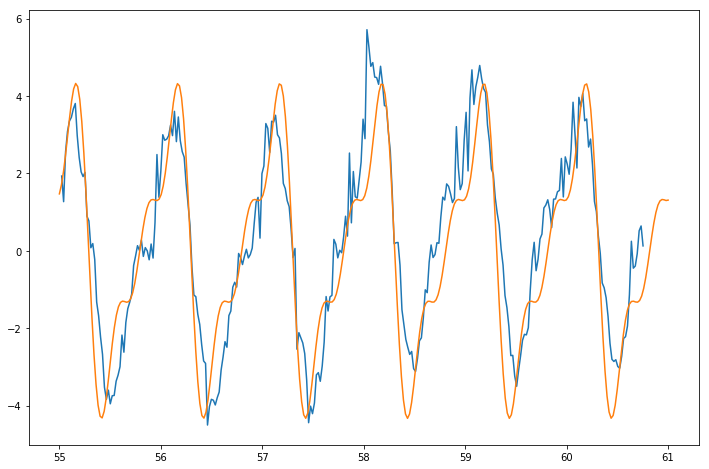

In [19]:
x=np.linspace(55,61,300)
y=[f(i,3,0.16,0.5) for i in x]
plt.figure(figsize=(12,8))
plt.plot(df.date_yrs.values[2800:3100],df.seasonality.values[2800:3100])

plt.plot(x,y)
plt.show()

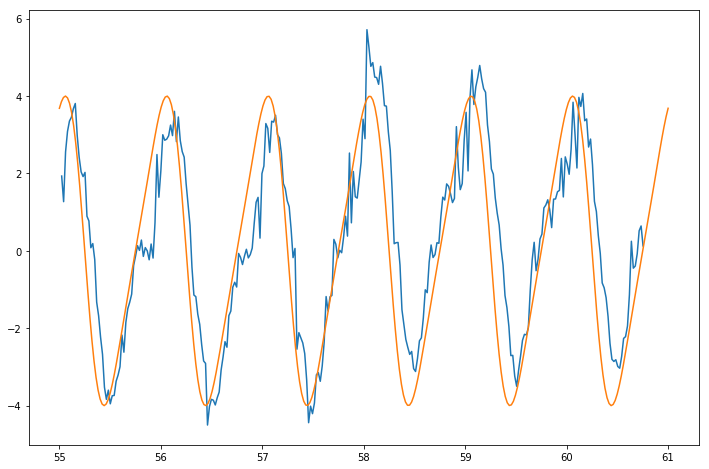

In [20]:
#assymetric cos function
def cos_assym(x):
    a=4
    s=0.4
    f=2*np.pi
    return 4*np.cos(f*x-s*np.cos(f*x))

x=np.linspace(55,61,300)
y=[cos_assym(i) for i in x]
plt.figure(figsize=(12,8))
plt.plot(df.date_yrs.values[2800:3100],df.seasonality.values[2800:3100])

plt.plot(x,y)
plt.show()

In [21]:
assymetric_seasonal_stan_code = """
data {
    int<lower=0> n_data;             // length of data
    real<lower=0> time[n_data];      // time since beginning of study
    real co2[n_data];               // co2 data
    real<lower=0> two_pi;
    
}
parameters {
    real<lower=0> a;  //amplitude
    real<lower=0> s;  //symmetry
    real<lower=0> c4;        // noise parameter in normal
    real phi_x;
    real phi_y;
} 
transformed parameters {
    real phi = atan2(phi_x,phi_y); /phase offset
}
model {
 
    // Priors
    phi_x ~ normal(0,1);
    phi_y ~ normal(0,1);
    a ~ normal(4, 0.1);
    s ~ normal(0.4, 0.1);
    c4 ~ gamma(1,0.2);
    for (i in 1:n_data) {
        co2[i] ~ normal(a*cos(two_pi*time[i]-s*cos(two_pi*time[i])+phi), c4); 
    }
}
"""
assymetric_seasonal_model = pystan.StanModel(model_code=assymetric_seasonal_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4acf13f6dcdcdc523ca99a4a47e2d3a NOW.
C:\Users\Armin\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Armin\AppData\Local\Temp\tmpc2lc8vyd\stanfit4anon_model_f4acf13f6dcdcdc523ca99a4a47e2d3a_5568784165585479415.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [22]:
#extract data
assymetric_results=assymetric_seasonal_model.sampling(data=seasonal_data, iter=2000, 
                              verbose=True, n_jobs=3,
                              control={'max_treedepth': 14, 'adapt_delta' : 0.999},
                              refresh = 10)

In [23]:
assymetric_samples = assymetric_results.extract()

In [24]:
o=1.16
assymetric_seasonal_line = assymetric_samples['a'].mean()*np.cos(2*np.pi*dfs.date_yrs.values- \
                                                             assymetric_samples['s'].mean()*np.cos(2*np.pi*dfs.date_yrs.values) + \
                                                             assymetric_samples["phi"].mean())


In [25]:
print(assymetric_samples['a'].mean())
print(assymetric_samples['s'].mean())
print(assymetric_samples['phi'].mean())

3.53907940829391
0.40598491507753354
-0.30826542859762784


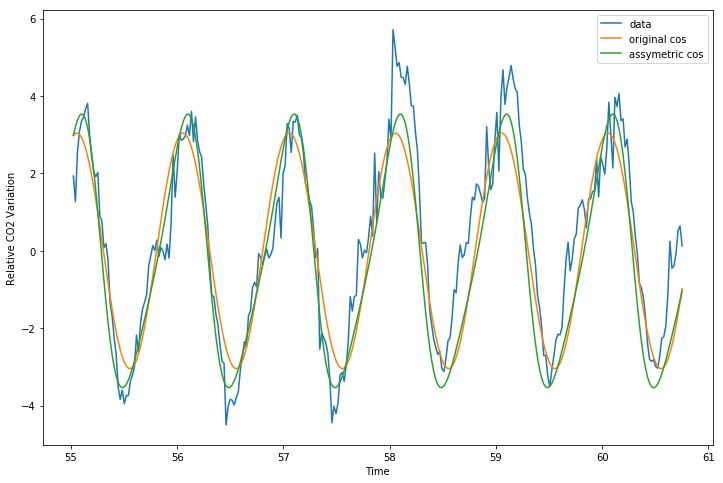

In [26]:
plt.figure(figsize=(12,8))
plt.plot(dfs.date_yrs.values,dfs.seasonality.values,label="data")
plt.plot(dfs.date_yrs.values,cos_seasonal_line,label="original cos")
plt.plot(dfs.date_yrs.values,assymetric_seasonal_line,label="assymetric cos")
plt.xlabel("Time")
plt.legend()
plt.ylabel("Relative CO2 Variation")
plt.savefig("assym.png",dpi=400)

In [27]:
#how much better a fit is this
#RSS
seasonality=dfs.seasonality.values
cos_model=cos_seasonal_line
assymetric_model=assymetric_seasonal_line
RSS_original=sum([(seasonality[i]-cos_model[i])**2 for i in range(len(seasonality))])
RSS_assymetric=sum([(seasonality[i]-assymetric_model[i])**2 for i in range(len(seasonality))])

print("The RSS of the original model:",RSS_original)
print("The RSS of the new, assymetric model:",RSS_assymetric)

The RSS of the original model: 352.1358603164619
The RSS of the new, assymetric model: 312.46392525548583


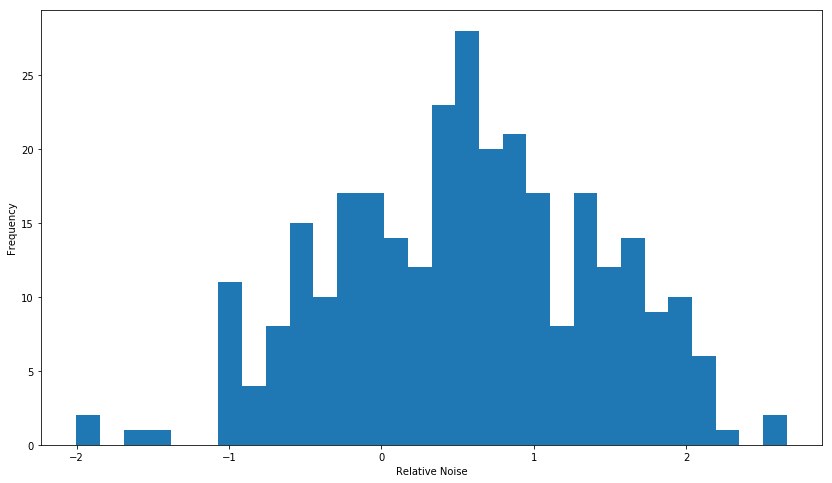

In [28]:
#noise distribution
assymetric=[(seasonality[i]-assymetric_model[i]) for i in range(len(seasonality))]
plt.figure(figsize=(14,8))
plt.hist(assymetric,bins=30)
plt.ylabel("Frequency")
plt.xlabel("Relative Noise")
plt.savefig("noise.png",dpi=400)

In [29]:
## IMPROVED MODEL WITH PREDICTIONS
dates_to_predict = pd.date_range("2019-10-05", "2058-01-05", freq='W-FRI')
predict_yrs = (dates_to_predict-df.date[0]).days/365.25

In [30]:
stan_data={
    "n_data":len(df),
    "co2": df.co2.values,
    "time":df.date_yrs.values,
    "two_pi": 2*np.pi,
    "n_predict": len(dates_to_predict),
    "time_predict": predict_yrs
}

In [31]:
# COMPREHENSIVE MODEL
stan_code = """
data {

    int<lower=0> n_data;             // length of data
    real<lower=0> time[n_data];      // time since beginning of study
    real co2[n_data];               // co2 data
    real<lower=0> two_pi;

    int<lower=0> n_predict;
    real<lower=0> time_predict[n_predict];
    
}

parameters {

  
    real<lower=0> c0;  // y intercept
    real<lower=0> c1;  // linear term
    real<lower=0> c2;  // quadratic term
    real c4;        // noise param in normal

    real<lower=0> a;  
    real<lower=0> s;  

    // periodic phi
    real phi_x;
    real phi_y;
}

transformed parameters {
    
    real phi = atan2(phi_x,phi_y) ;
}

model {
    
    // Priors
    phi_x ~ normal(0,1);
    phi_y ~ normal(0,1);
    c0 ~ normal(300, 30);
    c1 ~ normal(0,5);
    c2 ~ normal(1,1);
    a ~ normal(4, 0.1);
    s ~ normal(0.4, 0.1);
    c4 ~ gamma(2,1);
    
    for (i in 1:n_data) {
        co2[i] ~ normal(c2*time[i]^2+c1*time[i]+c0+a*cos(two_pi*time[i]-s*cos(two_pi*time[i])+phi), c4);

    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_predicted[n_predict];
    for(i in 1:n_predict) {
        x_predicted[i] = normal_rng(
            c2*time_predict[i]^2+c1*time_predict[i]+c0+a*cos(two_pi*time_predict[i]-s*sin(two_pi*time_predict[i])+phi), c4
            );
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ce3ab5d9e153ab74ce6a3cc95adb3f4 NOW.
C:\Users\Armin\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Armin\AppData\Local\Temp\tmpa8qyh2gt\stanfit4anon_model_9ce3ab5d9e153ab74ce6a3cc95adb3f4_790700641964679284.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [32]:
stan_results = stan_model.sampling(data=stan_data)
stan_results

Inference for Stan model: anon_model_9ce3ab5d9e153ab74ce6a3cc95adb3f4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0                314.82  1.2e-3   0.05 314.72 314.79 314.82 314.85 314.91   1679    1.0
c1                  0.77  9.4e-5 3.4e-3   0.76   0.77   0.77   0.77   0.78   1283    1.0
c2                  0.01  1.5e-6 5.3e-5   0.01   0.01   0.01   0.01   0.01   1274    nan
c4                  0.88  2.1e-4   0.01   0.86   0.88   0.88   0.89   0.91   2775    1.0
a                   3.07  4.8e-4   0.02   3.03   3.06   3.07   3.09   3.12   2497    1.0
s                   0.41  2.6e-4   0.01   0.38    0.4   0.41   0.41   0.43   2474    1.0
phi_x              -0.54    0.02   0.27  -1.13  -0.71   -0.5  -0.34  -0.15    311   1.01
phi_y               1.16    0.03   0.57   0.32   0.72   1.08   1.52   2.42    312   1.01
phi       

In [33]:
samples=stan_results.extract()

In [34]:
#check model by generating data for 1958 to today based on posteriors
c0=np.mean(samples['c0'])
c1=np.mean(samples['c1'])
c2=np.mean(samples['c2'])
c4=np.mean(samples['c4'])
a=np.mean(samples['a'])
s=np.mean(samples['s'])
phi=np.mean(samples['phi'])

comparison_data= c0+(c1*df.date_yrs.values+c2*df.date_yrs.values**2+
                  a*np.cos(2*np.pi*df.date_yrs.values- s*np.cos(
                  2*np.pi*df.date_yrs.values)+phi))


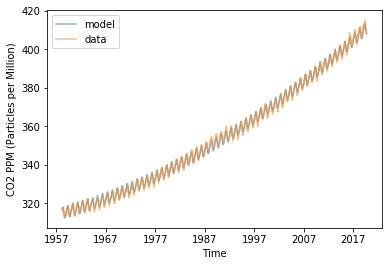

In [35]:
#see how it fits the data
plt.figure()
plt.plot(df.date.values,comparison_data,label="model",alpha=0.5)
plt.plot(df.date.values,df.co2.values,label="data",alpha=0.5)
plt.xlabel("Time")
plt.ylabel("CO2 PPM (Particles per Million)")
plt.legend()
plt.savefig("data check.png",dpi=400)

In [46]:
#generate samples from our posterior samples
generated_samples=[]
indices=np.arange(0,4000)
indices=np.random.choice(indices,size=100, replace=False)

for e,i in enumerate(indices):
    if e%50==0:
        print(e)
    temp=[]
    for t in df["date_yrs"]:
        a=np.random.normal(samples["c0"][i]+samples["c1"][i]*t+
                         samples["c2"][i]*t**2+samples["a"]*
                         np.cos(2*np.pi*t-samples["s"][i]*np.cos(2*np.pi*t)
                               +samples["phi"][i]),samples["c4"][i])
        temp.append(a)
    generated_samples.append(temp)

0
50


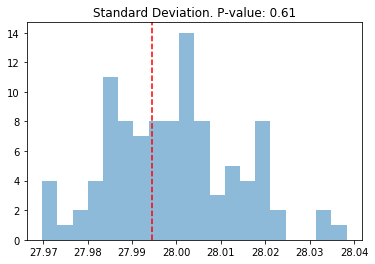

In [66]:
#compare samples to original data by
#standard deviation
std=[np.std(i) for i in generated_samples]
og_mean=np.std(df.co2.values)
p_value=0
for i in std:
    if i>og_mean:
        p_value+=1
p_value*=1/len(std)

plt.hist(std,alpha=0.5, bins=20)
plt.axvline(og_mean,color="red",ls="dashed",label="original mean")
plt.title(f"Standard Deviation. P-value: {p_value}")
plt.savefig("std.png",dpi=400)

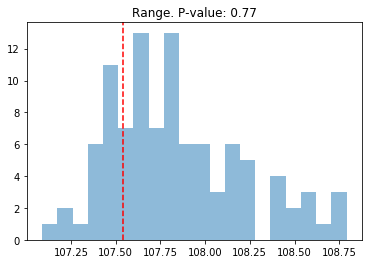

In [65]:
#range
ranges=[np.max(i)-np.min(i) for i in generated_samples]
og_range=(max(df.co2.values)-min(df.co2.values))
p_value=0
for i in ranges:
    if i>og_range:
        p_value+=1
p_value*=1/len(ranges)

plt.hist(ranges,alpha=0.5, bins=20)
plt.axvline(og_range,color="red",ls="dashed",label="original mean")
plt.title(f"Range. P-value: {p_value}")
plt.savefig("range.png",dpi=400)

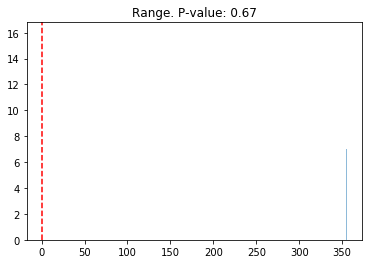

In [62]:
#mean
means=[np.mean(i) for i in generated_samples]
og_mean=np.mean(df.co2.values)
p_value=0
for i in means:
    if i>og_mean:
        p_value+=1
p_value*=1/len(means)

plt.hist(means,alpha=0.5)
plt.axvline(og_mean,color="red",ls="dashed",label="original mean")
plt.title(f"Mean. P-value: {p_value}")
plt.savefig("mean.png",dpi=400)

In [ ]:
#extract means
x_predicted=np.transpose(samples['x_predicted'])
future_co2=[np.mean(i) for i in x_predicted]   

In [ ]:
#extract 95% confint
lower=[np.percentile(i,2.5) for i in x_predicted]
upper=[np.percentile(i,97.5) for i in x_predicted]

In [ ]:
#when does it reach 450
indices=[]
for i,value in enumerate(future_co2):
    if value>450 and value<451:
        indices.append(i)
first=indices[0]
last=indices[-1]

In [ ]:
#plot figure 16
plt.figure(figsize=(14,8))
plt.plot(dates_to_predict,future_co2,label="predicted co2 levels")
plt.plot(dates_to_predict,lower,"--",color='red',alpha=0.5,label="95% confidence lower bound")
plt.plot(dates_to_predict,upper,"--",color='red',alpha=0.5,label="95% confidence upper bound")
plt.axvline(dates_to_predict[first],color='black',ls="dashed")
plt.axvline(dates_to_predict[last],color='black',ls="dashed")
plt.axhline(450,color="green",ls="dashed",label="450 ppm")
plt.axvspan(dates_to_predict[first],dates_to_predict[last],
            color="orange",alpha=0.2, label="450ppm first reached")
plt.xlabel("Year")
plt.ylabel("CO2 ppm")
plt.legend()
plt.xlim(dates_to_predict[0],dates_to_predict[-1])
plt.title("CO2 Levels Predicted Until 2058")
plt.savefig("Predicted_Levels.png",dpi=400)

In [ ]:
#autocorrelation plots from session 14.1
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    return plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

parameters = ['c0', 'c1','c2','a','s','phi','c4']
plots=[]
fig,axes=plt.subplots(4,2, figsize=(14,8))
for j,i in enumerate(parameters):
    plt.subplot(2,4,j+1)
    plot_acf(samples[i])
    plt.title(f'Autocorrelation for {i} samples')

plt.savefig('autocorrelations.png',dpi=400)

In [ ]:
#from session 14.1
#pairplot to illustrate multidimensional distribution
plt.figure(figsize=(14,14))
pairplot_data=np.transpose([samples[i] for i in parameters])
parameterdf=pd.DataFrame(data=pairplot_data,columns=parameters)
seaborn.pairplot(parameterdf, plot_kws={'marker': '.', 'alpha': 0.25})
plt.savefig("pairplot.png",dpi=400)